# Kwaterniony model AR (Levinson-Durbin)
--- 

## Wczytanie danych
---

Stabilny zapis lotu `38_bs78_out_GPS_alt2pos.ulg`.

In [12]:
import pyulog
from library.data_reader import read_attitude_quaternions, read_nav_quaternions

log = pyulog.ULog('./ulogs/38_bs78_out_GPS_alt2pos.ulg')
att_q, att_t = read_attitude_quaternions(log)
nav_q, nav_t = read_nav_quaternions(log)

## Interpolacja
---

Zaimplementowano metodę bazującą na *interpolacja funkcjami sklejanymi*, jako `spline_interpolation()`, dostarczającą bliskie wyniki. Zaimplementowano również metodę bazującą na metodzie *slerp*, jako funkcję `squad_interpolation`.  

Dla zachowania ciągłości napisano funkcję zwracającą indeksy podsekwencji rozdzielonych maksymalną odległością `discontinued_subspaces`

In [13]:
import numpy as np
from library.quaternion_interp import discontinued_subspaces, spline_interpolation

# Get pseudo continuous signal (max space 10ms)
max_space = 10e4

args_partial_signal = discontinued_subspaces(att_t, max_length = max_space)
args_part = args_partial_signal[0] # Get first part

att_t = att_t[args_part[0]:args_part[1]]
att_q = att_q[args_part[0]:args_part[1]]

# Config interpolation
dt = 4000
degree = 3

est_t = np.arange(att_t[0], att_t[-1], dt)
est_q = spline_interpolation(att_q, att_t, est_t, spline_degree=degree)

### Wynik interpolacji (składowe kwaternionu)

Do wyświetlenie rezultatów można wykorzystać `display_quaternion_compare` dla składowych kwaternionu.

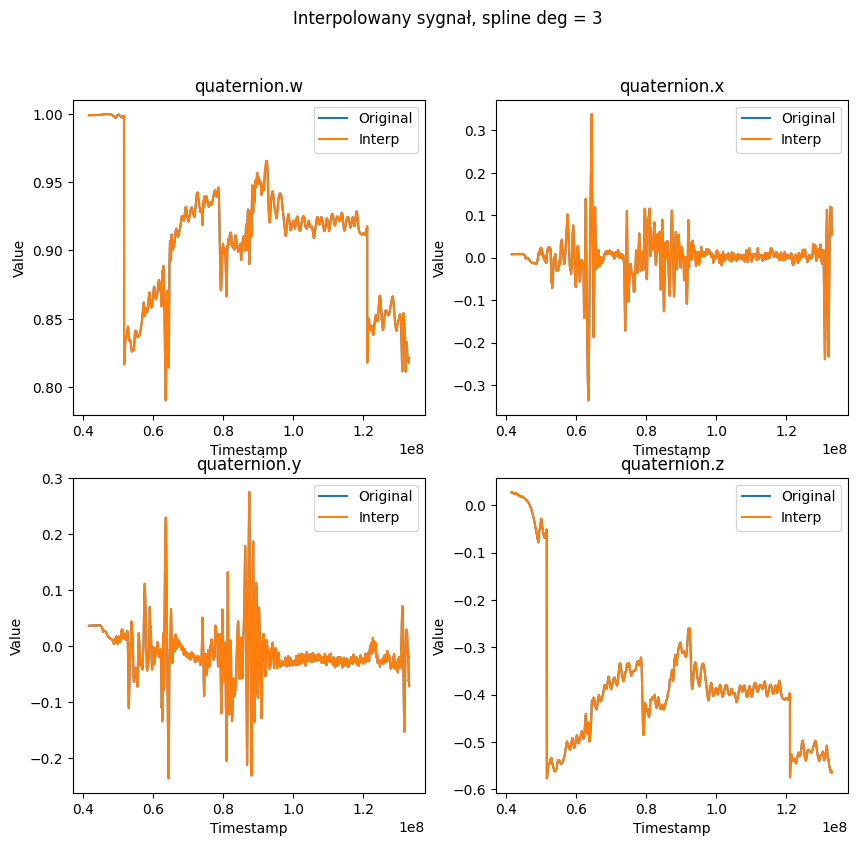

In [14]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, spline deg = {}".format(degree))

### Wynik interpolacji (kąty Eulera)

W przypadku kątów Eulera `display_quaternion_as_euler`. 

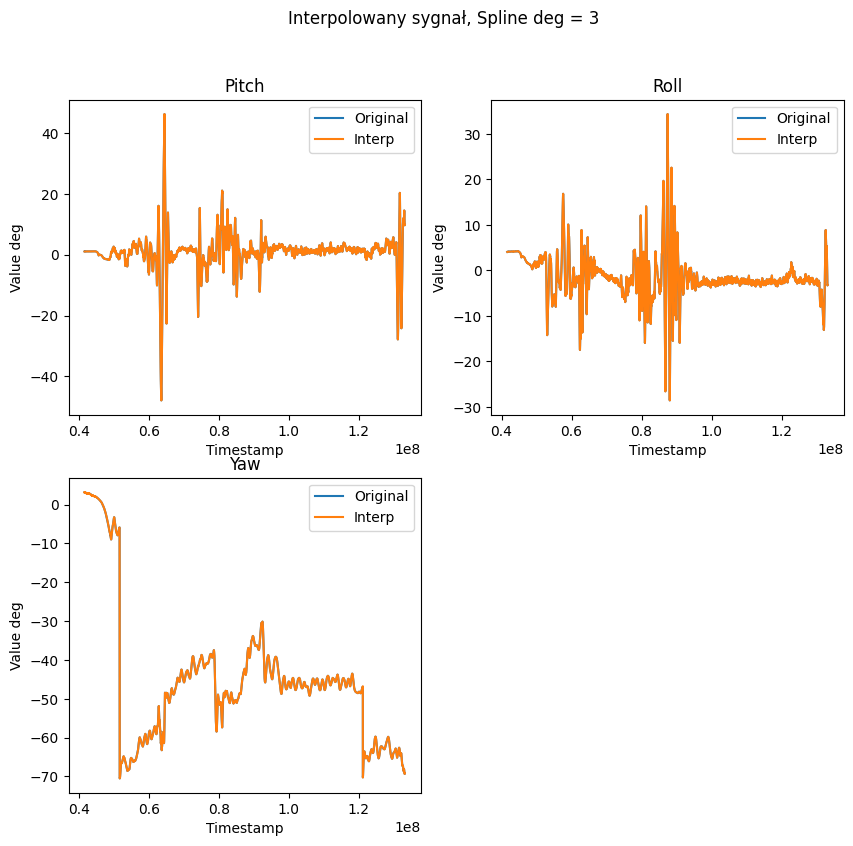

In [15]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, Spline deg = {}".format(degree))

## Implementacja modelu AR
---

### Macierz autokorelacji


\begin{gather}
    \begin{bmatrix}
    r_{1}(0) & \overline{r_{2}(1)} & \cdots & \overline{r_{p}(p-1)}\\ 
    r_{2}(1) & r_{2}(0) & \cdots & \overline{r_{p}(p-2)}\\ 
    \vdots  & \vdots  & \ddots  & \vdots\\ 
    r_{p}(p-1) & r_{p}(p-2) & \cdots & r_{p}(0)
    \end{bmatrix} 

    \begin{bmatrix} 
    a_1\\ 
    a_2\\ 
    \vdots \\ 
    a_p
    \end{bmatrix}
    =
    \begin{bmatrix} 
    r(1)\\ 
    r(2)\\ 
    \vdots \\ 
    r(p)
    \end{bmatrix}

\end{gather}

\begin{gather}
    \begin{bmatrix} 
    a_1\\ 
    a_2\\ 
    \vdots \\ 
    a_p
    \end{bmatrix}
    =
    \textbf{R}^{-1}

    \begin{bmatrix} 
    r(1)\\ 
    r(2)\\ 
    \vdots \\ 
    r(p)
    \end{bmatrix}
\end{gather}

### Levinson-Durbin 

Założenia: Macierz autokorelacji jest macierzą Toeplitza.

1. Wyznaczenia wartości początkowych

$a_0^{(0)} = 1$

2. Wyznaczenie współczynnika na P=

$a_1^{(1)} = \frac{r(1)}{r(0)}$ 

3. Rekurencyjne wyznaczanie współczynników

$a_P^{(P)} = \frac{r_P - \textbf{a}^{(P-1)}\widetilde{\textbf{r}}^{(P-1)}}{r_0 - \widetilde{\textbf{a}}^{(P-1)}\widetilde{\textbf{r}}^{(P-1)}}$

$a_i^{(P)} = a_i^{(P-1)} - a_P^{(P)}a_{P-i}^{(P-1)}$




#### Test poprawoności (3 rząd) - kwaterniony

**Krok 1**:

$a_1^{(1)} = \frac{r(1)}{r(0)}$ 

Sprawdzając:
$a_1^{(1)}r(0) = \frac{r(1)}{r(0)}r(0) = r(1)$

**Krok 2**:

$a_2^{(2)} = \frac{r(2) - a_1^{(1)}r(1)}{r(0) - a_1^{(1)}r(1)} = \frac{r(2) - \frac{r(1)}{r(0)}r(1)}{r(0) - \frac{r(1)}{r(0)}r(1)}$ 

$a_1^{(2)} = a_1^{(1)} - a_2^{(2)}a_1^{(1)} = \frac{r(1)}{r(0)} - \frac{r(2) - \frac{r(1)}{r(0)}r(1)}{r(0) - \frac{r(1)}{r(0)}r(1)} \frac{r(1)}{r(0)}$ 

Sprawdzając:

$a_1^{(2)}r(0) + a_2^{(2)}r(1) = r(1) - a_2^{(2)}r(1) + a_2^{(2)}r(1) = r(1)$

$a_1^{(2)}r(1) + a_2^{(2)}r(0) = 
\frac{r(1)}{r(0)}r(1)-a_2^{(2)}\frac{r(1)}{r(0)}r(1) + a_2^{(2)}r(0) = 
\frac{r(1)}{r(0)}r(1) + a_2^{(2)}(r(0)-\frac{r(1)}{r(0)}r(1)) = 
\frac{r(1)}{r(0)}r(1) + r(2) - \frac{r(1)}{r(0)}r(1) = r(2)$

**Krok 3**:

$a_3^{(3)} = \frac{r3 - a_1^{(2)}r(2) - a_2^{(2)}r(1)}{r0 - a_2^{(2)}r(2) - a_1^{(2)}r(1)} = 
\frac{r(3) - a_2^{(2)}(\frac{r(1)}{r(0)}r(2)+r(1))-\frac{r(1)}{r(0)}r(2)}{r(0)- a_2^{(2)}(\frac{r(1)}{r(0)}r(1)+r(2))-\frac{r(1)}{r(0)}r(1)}$ 

$a_2^{(3)} = a_2^{(2)} - a_3^{(3)}a_1^{(2)}$

$a_1^{(3)} = a_1^{(2)} - a_3^{(3)}a_2^{(2)}$

Sprawdzając:

$a_1^{(3)}r(0) + a_2^{(3)}r(1) + a_3^{(3)}r(2) = r(1)$ <br>
$r(1)-a_2^{(2)}r(1)-a_3^{(3)}a_2^{(2)}r(0) + a_2^{(2)}r(1) - a_3^{(3)}(\frac{r(1)}{r(0)}r(1) - a_2^{(2)}\frac{r(1)}{r(0)}r(1)) + a_3^{(3)}r(2)=$ <br>
$r(1)-a_3^{(3)}a_2^{(2)}r(0) - a_3^{(3)}(\frac{r(1)}{r(0)}r(1) - a_2^{(2)}\frac{r(1)}{r(0)}r(1)) + a_3^{(3)}r(2)=$ <br>
$r(1)+a_3^{(3)}[-a_2^{(2)}r(0) - \frac{r(1)}{r(0)}r(1) - a_2^{(2)}\frac{r(1)}{r(0)}r(1) + r(2)] = $  <br>
$r(1)+a_3^{(3)}[-a_2^{(2)}(r(0)- \frac{r(1)}{r(0)}r(1))- \frac{r(1)}{r(0)}r(1) + r(2)] = $  <br>
$r(1)+a_3^{(3)}[-r(2) + \frac{r(1)}{r(0)}r(1) - \frac{r(1)}{r(0)}r(1) + r(2)] = $  <br>
$r(1) = r(1)$

$a_1^{(3)}r(1) + a_2^{(3)}r(0) + a_3^{(3)}r(1) = r(2)$ <br>
$\frac{r(1)}{r(0)}r(1)-a_2^{(2)}\frac{r(1)}{r(0)}r(1)-a_3^{(3)}a_2^{(2)}r(1)+a_2^{(2)}r(0)-a_3^{(3)}(r(1) - a_2^{(2)}r(1)) + a_3^{(3)}r(1)=$ <br>
$a_3^{(3)}[-a_2^{(2)}r(1)+a_2^{(2)}r(0)-r(1) + a_2^{(2)}r(1)+r(1)]+a_2^{(2)}(r(0) -\frac{r(1)}{r(0)}r(1)) +\frac{r(1)}{r(0)}r(1)=$ <br>
$r2-\frac{r(1)}{r(0)}r(1)+\frac{r(1)}{r(0)}r(1) =$<br>
$r(2)=r(2)$

$a_1^{(3)}r(2) + a_2^{(3)}r(1) + a_3^{(3)}r(0) = r(3)$ <br>
$\frac{r(1)}{r(0)}r(2) - a_2^{(2)}\frac{r(1)}{r(0)}r(2)-a_3^{(3)}a_2^{(2)}r(2)+a_2^{(2)}r(1) - a_3^{(3)}(\frac{r(1)}{r(0)}r(1)-a_2^{(2)}\frac{r(1)}{r(0)}r(1)) + a_3^{(3)}r(0)=$<br>
$a_3^{(3)}[r0 + a_2^{(2)}(\frac{r(1)}{r(0)}r(1)-r(2))-\frac{r(1)}{r(0)}r(1)] - a_2^{(2)}(\frac{r(1)}{r(0)}r(2)-r1) + \frac{r(1)}{r(0)}r(1) = $<br>
$r(3)+a_2^{(2)}(\frac{r(1)}{r(0)}r(2)-r1) - \frac{r(1)}{r(0)}r(1)- a_2^{(2)}(\frac{r(1)}{r(0)}r(2)-r1) + \frac{r(1)}{r(0)}r(1) = $ <br>
$r(3) = r(3)$

## Test predykcji
---

In [16]:
from library.quaternion_pred import compute_correlation_matrix
from library.quaternion_pred import compute_coefficient_LD

# Configuration section
N_window = 30
M_order = 3

pred_window = {
    'min': 5000 + N_window,
    'max': est_t.shape[0],
}
ex_q   = est_q[pred_window['min']:pred_window['max']]
pred_q = np.zeros((pred_window['max'] - pred_window['min']), dtype = np.quaternion)
ex_t = pred_t = est_t[pred_window['min']:pred_window['max']]

for i in range(pred_window['min'], pred_window['max']):
    r_matrix = compute_correlation_matrix(est_q[i-N_window : i][::-1], M_order)
    a_arr = compute_coefficient_LD(r_matrix, M_order)
    pred_q[i - pred_window['min']] = np.sum(a_arr * est_q[i-M_order : i][::-1]).normalized()


### Uzyskane rezultaty

#### MSE dla kątów Eulera

In [17]:
from library.quaternion_utils import quaternion_euler_mse, quaternion_euler_difference

EULER_COMPONENTS = ['Pitch', 'Roll', 'Yaw']
mse_e = quaternion_euler_mse(ex_q, pred_q)
for mse, c in zip(mse_e, EULER_COMPONENTS):
    print(f'{c+" mse:": <10} {mse}')

diff_e = quaternion_euler_difference(ex_q, pred_q)
max_e = np.max(diff_e, axis=0)
for max_e, c in zip(max_e, EULER_COMPONENTS):
    print(f'{c+" Max err :": <15} {max_e}')


Pitch mse: 0.061784534644864296
Roll mse:  0.05046605304553483
Yaw mse:   0.03548817498932262
Pitch Max err : 1.42222661084827
Roll Max err :  1.2232504352120088
Yaw Max err :   23.316846857521824


#### Wykres predykcji

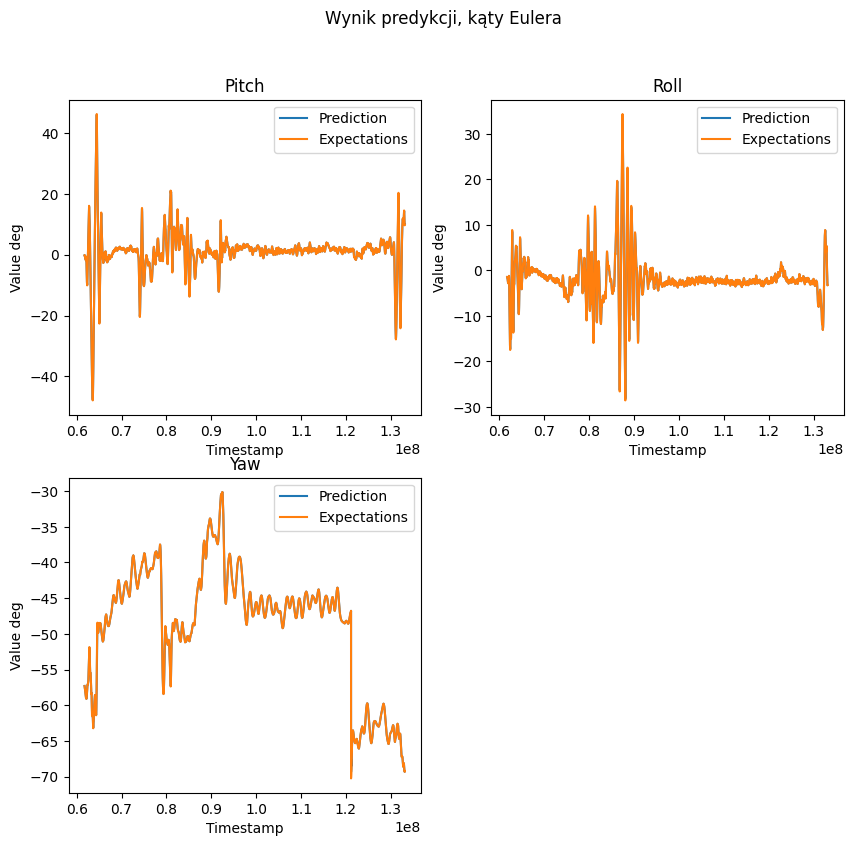

In [18]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler(
    [pred_q, ex_q], 
    [pred_t, ex_t],  
    ['Prediction', 'Expectations'],
    "Wynik predykcji, kąty Eulera")

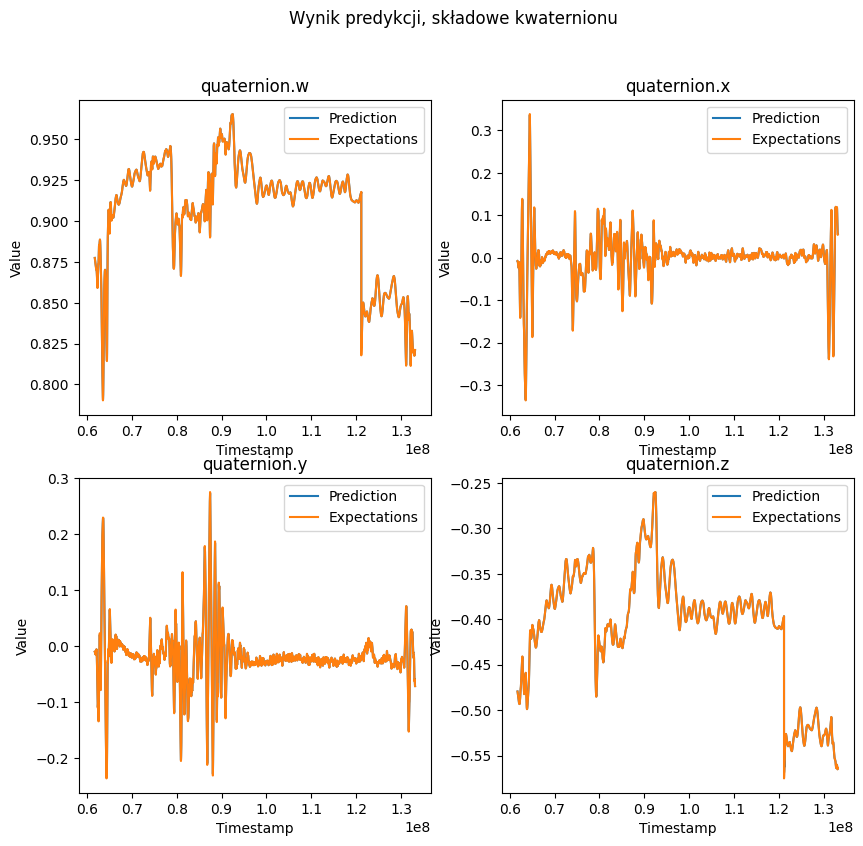

In [19]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare(
    [pred_q, ex_q], 
    [pred_t, ex_t], 
    ['Prediction', 'Expectations'],
    "Wynik predykcji, składowe kwaternionu")